In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from utils.utils import evaluate_rf_model_with_cm, TiffDataset
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pandas as pd

In [2]:
from torchvision import transforms
import torch

class ReshapeTransform:
    """(12*bands, 9, 9) → (12, bands, 9, 9) → (bands, 12, 9, 9) 변환"""
    def __init__(self, bands):
        self.bands = bands

    def __call__(self, x):
        return x.view(12, self.bands, 9, 9).permute(1, 0, 2, 3).contiguous()

def flatten_transform(x):
    """(bands, 12, 9, 9) → (bands × 12 × 9 × 9,) 벡터로 변환"""
    return x.reshape(-1)  # 또는 x.contiguous().view(-1)

def get_transform(bands, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands),  # (12*bands, 9, 9) → (bands, 12, 9, 9)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정
    
    transform_list.append(transforms.Lambda(flatten_transform))  # 1D 벡터 변환
    return transforms.Compose(transform_list)

# 채널 값 조정 함수
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if x.shape[0] > 4:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x


In [3]:
# 5️⃣ 학습 및 평가 함수
def train_rf_model(train_loader, model):
    X_all, y_all = [], []

    # 미니배치 단위로 데이터 수집
    for X_batch, y_batch in train_loader:
        X_all.append(X_batch.numpy())  # NumPy 변환
        y_all.append(y_batch.numpy())

    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)

    # 모델 학습
    model.fit(X_all, y_all)

In [4]:
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소
bands = 4 #밴드 수
patch_size = 9

transform = get_transform(bands, scale_channels)

In [5]:
val_filters = [
    lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49} ,
    lambda x: x >= 2 and (x % 50) in {2, 7, 14, 19, 21, 26, 33, 38, 45, 0}  ,
    lambda x: x >= 3 and (x % 50) in {3, 8, 15, 20, 22, 27, 34, 39, 41, 46},
    lambda x: x >= 4 and (x % 50) in {4, 9, 11, 16, 23, 28, 35, 40, 42, 47 }  ,
    lambda x: x >= 5 and (x % 50) in {5, 10, 12, 17, 24, 29, 31, 36, 43, 48},
]

Evaluation Progress: 100%|███████████████████████████████████| 936/936 [00:28<00:00, 33.01it/s]


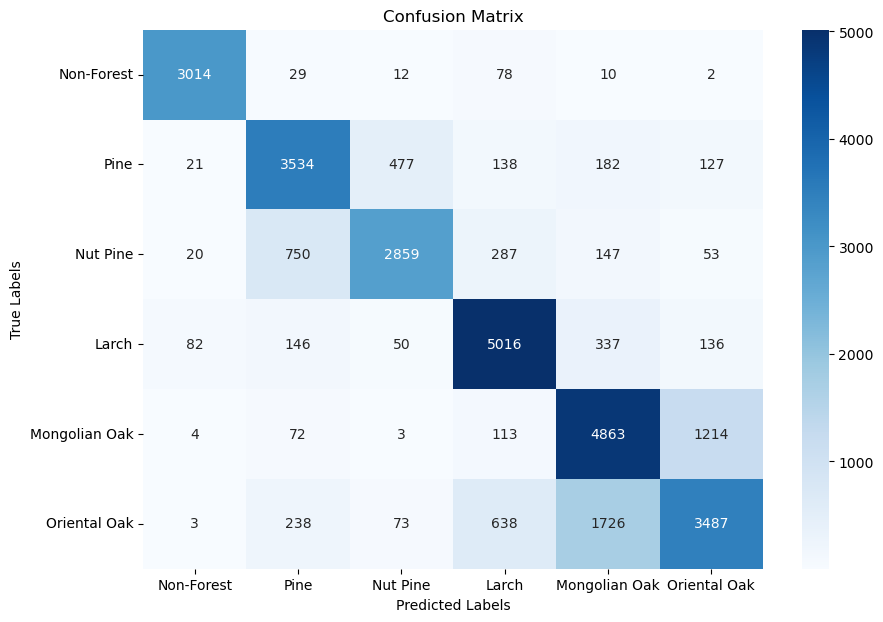

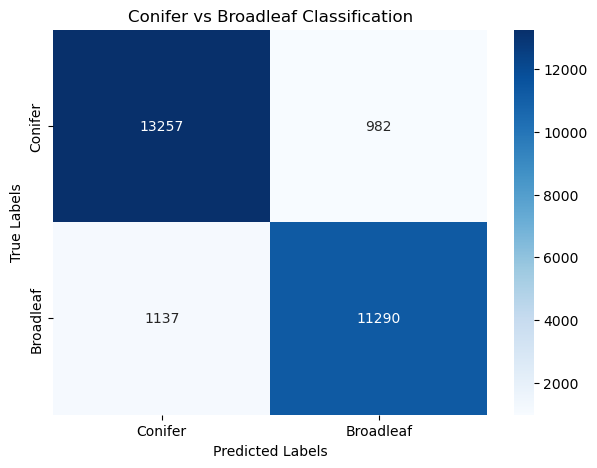

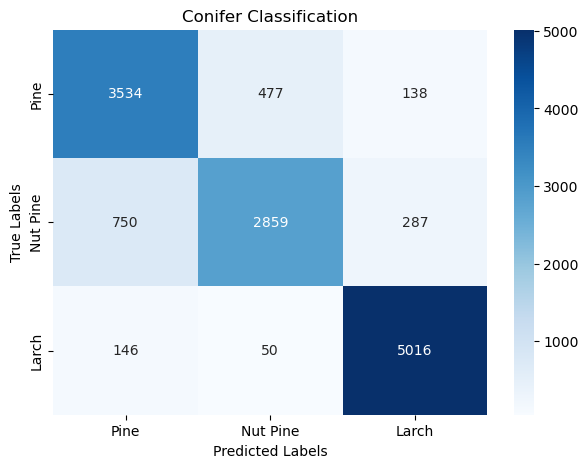

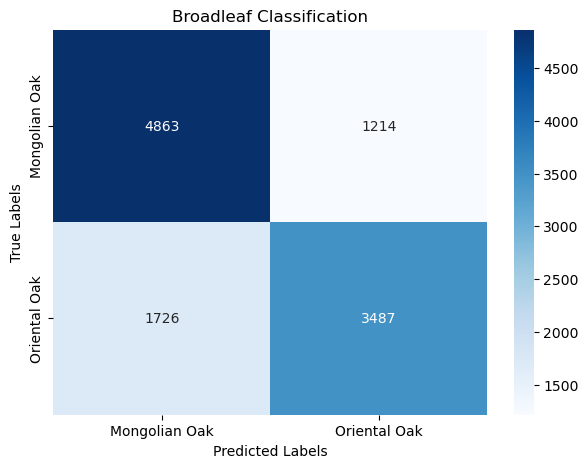

Evaluation Progress: 100%|███████████████████████████████████| 784/784 [00:24<00:00, 32.47it/s]


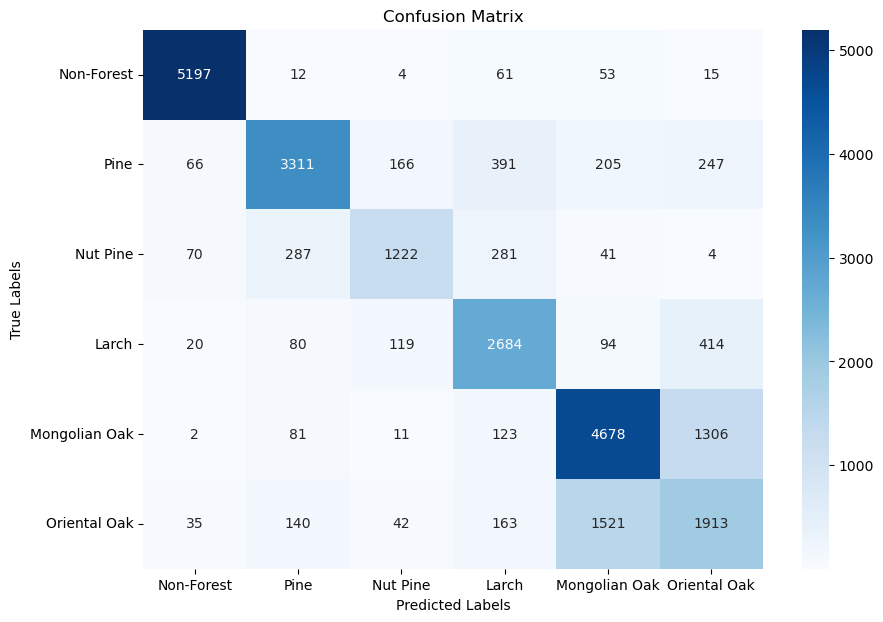

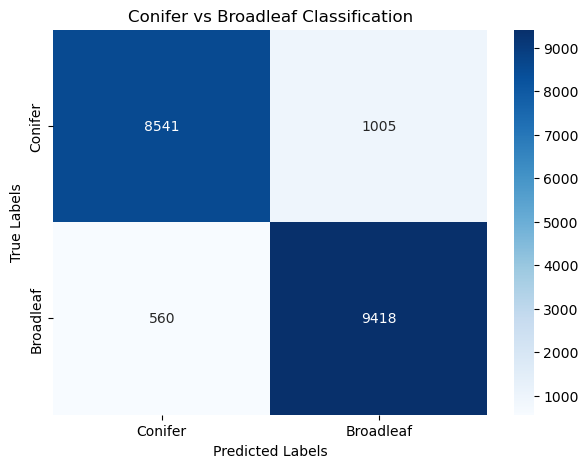

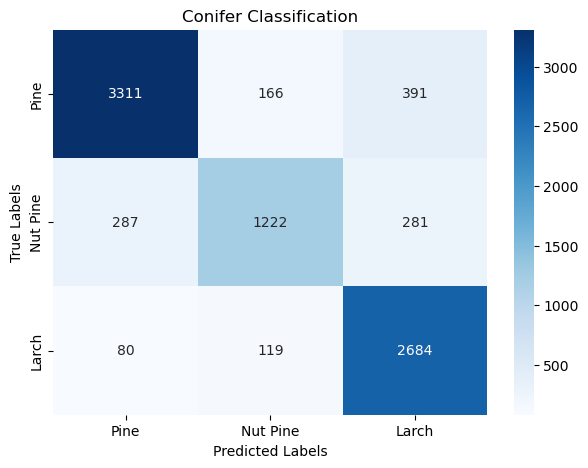

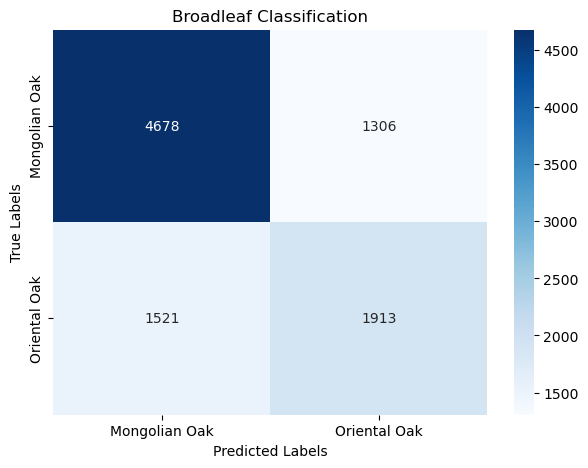

Evaluation Progress: 100%|█████████████████████████████████| 1053/1053 [00:31<00:00, 32.92it/s]


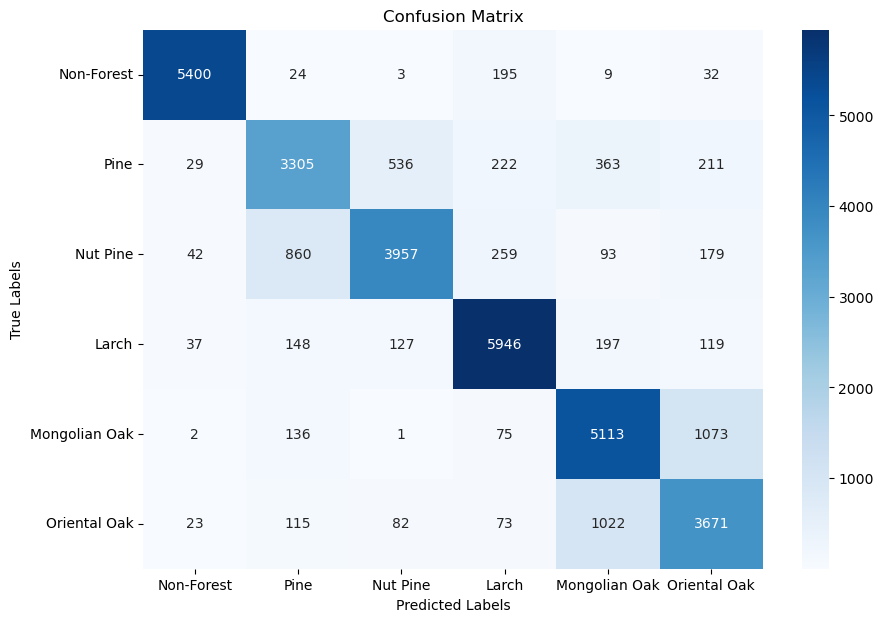

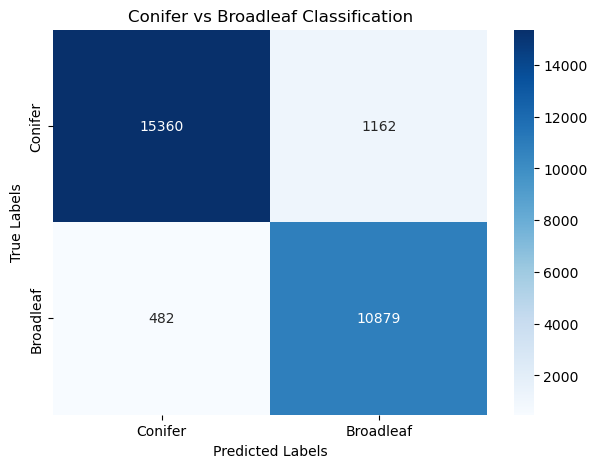

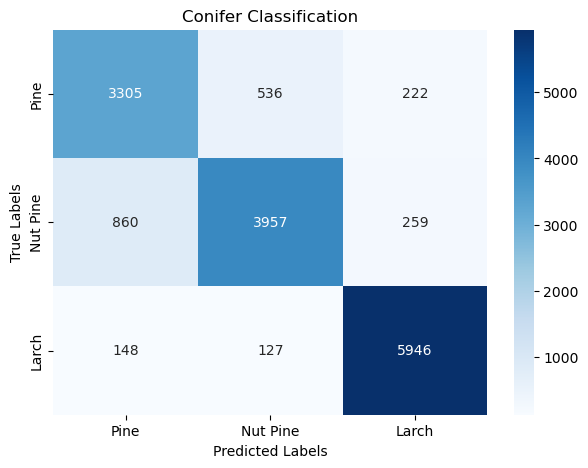

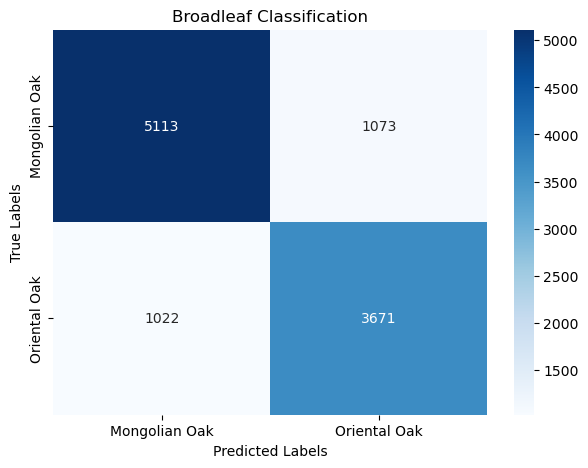

Evaluation Progress: 100%|█████████████████████████████████| 1001/1001 [00:30<00:00, 32.31it/s]


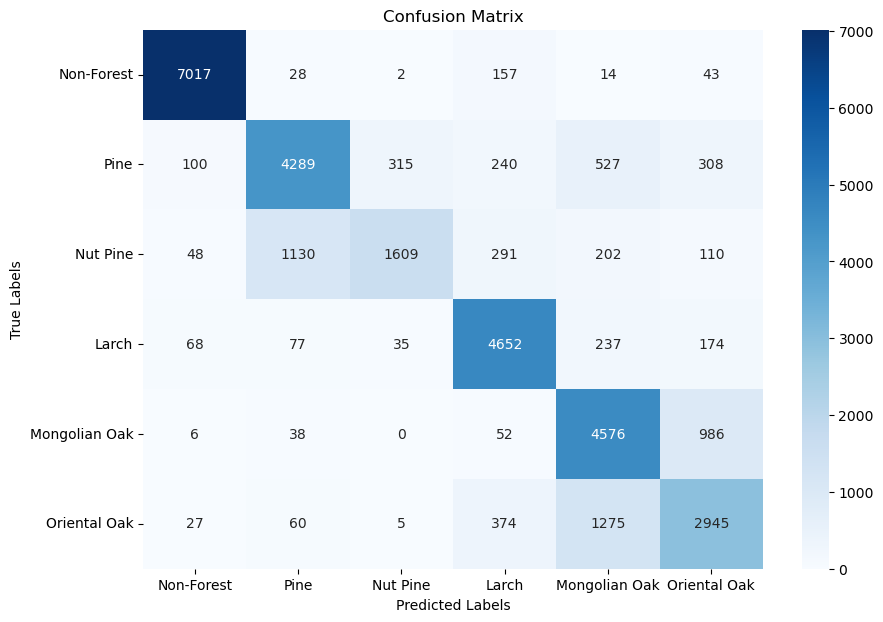

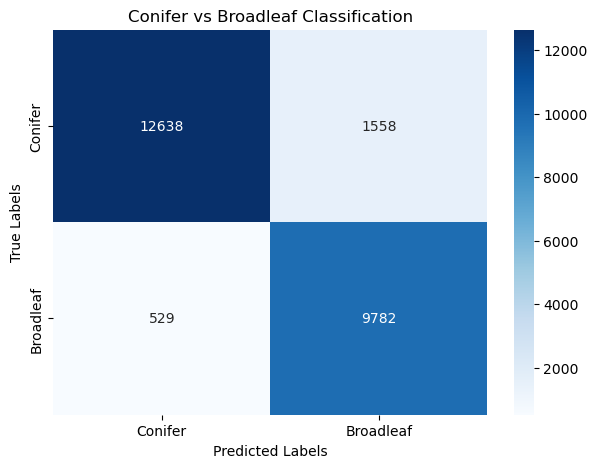

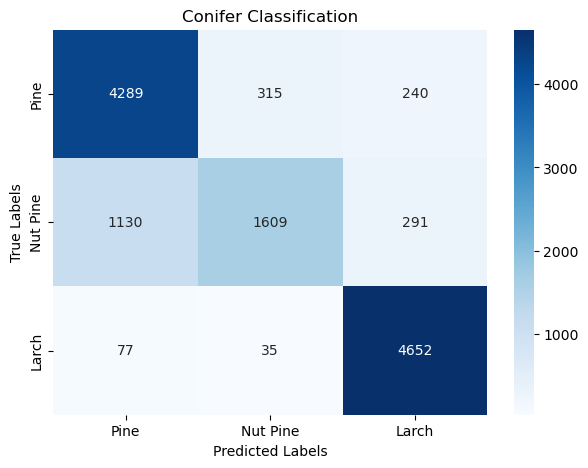

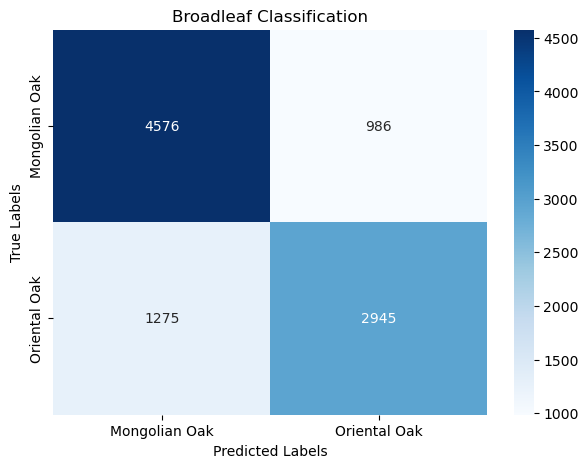

Evaluation Progress: 100%|███████████████████████████████████| 937/937 [00:28<00:00, 32.91it/s]


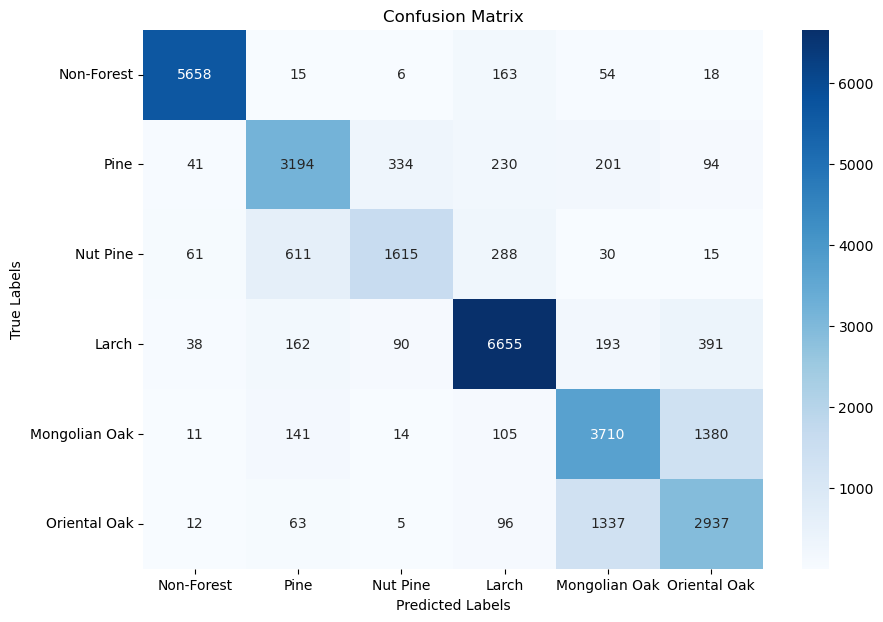

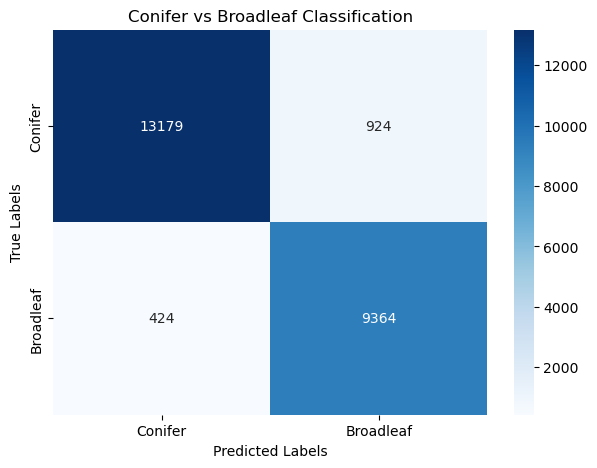

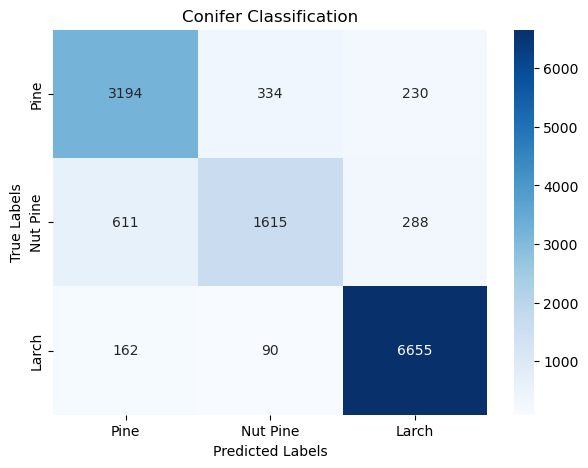

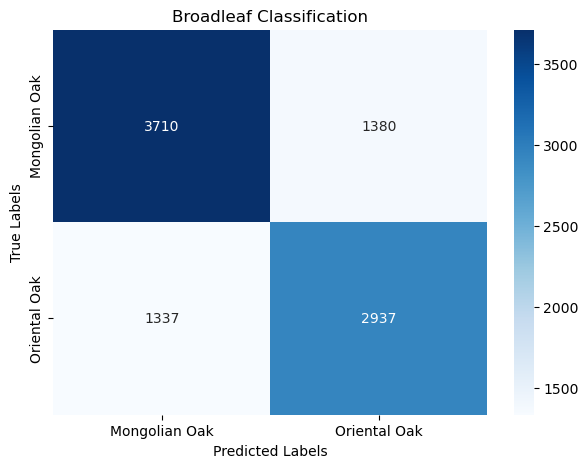

NameError: name 'pd' is not defined

In [6]:
result_df = {} #반환하는 데이터 프레임을 딕셔너리로 만들기

for idx, val_filter in enumerate(val_filters):
    #data loader만들기
    train_dataset = TiffDataset(
        large_tif_dir = large_tif_dir,
        file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
        label_file = "../../data/label_data/species/label_mapping_sampled.csv",
        box_filter_fn = lambda box_number: not val_filter(box_number),
        patch_size = patch_size,
        transform=transform
    )
    
    val_dataset = TiffDataset(
        large_tif_dir = '../../data/source_data/naive',
        file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
        label_file ="../../data/label_data/species/label_mapping_sampled.csv",
        box_filter_fn = val_filter,
        patch_size = patch_size,
        transform=transform
    )
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    #모델 생성, pth 업로드
    model = Pipeline([
        ("scaler", StandardScaler()),  # 정규화
        ("classifier", RandomForestClassifier(
            n_estimators=100,  # 트리 개수
            max_depth=10,  # 트리 최대 깊이
            min_samples_split=5,  # 최소 분할 샘플 수
            min_samples_leaf=2,  # 최소 리프 샘플 수
            random_state=42,
            n_jobs=-1  # 병렬 처리
        ))
    ])
    train_rf_model(train_loader, model)
    
    #결과 딕셔너리에 추가
    result_df[idx] = evaluate_rf_model_with_cm(model, val_loader, num_classes=6)
    
    #메모리 확보
    del model, val_loader, train_loader
    
# 결과 저장 경로 설정
save_path = "./results/rf.csv"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 모든 데이터프레임을 하나로 합치기
dfs = []
for key, df in result_df.items():
    df = df.copy()
    df["dataset"] = key  # 데이터셋 열 추가
    df = df.reset_index().rename(columns={"index": "class"})
    dfs.append(df)

# 데이터프레임 병합
final_df = pd.concat(dfs, ignore_index=True)

# CSV 저장
final_df.to_csv(save_path, encoding="utf-8-sig", index=False)

print(f"CSV 파일이 저장되었습니다: {save_path}")